In [113]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

SignificanceResult(statistic=-0.2771252926084785, pvalue=4.735712760709491e-70)
MSE 1224.5603798161278


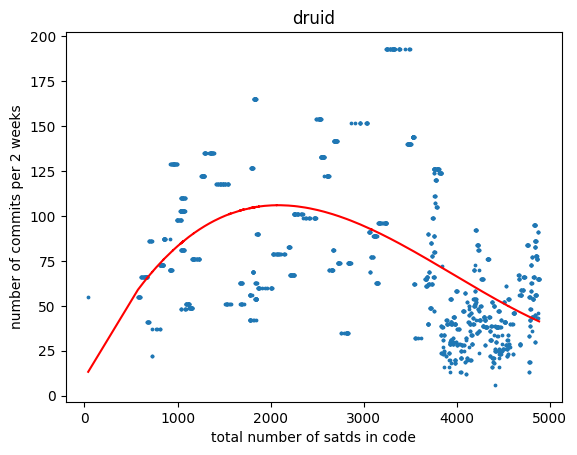

SignificanceResult(statistic=-0.2551153064315706, pvalue=1.026320615203773e-25)
MSE 603.1076942496845


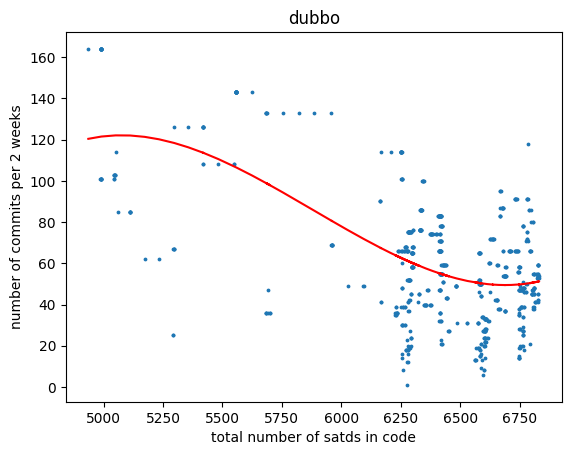

SignificanceResult(statistic=0.41142117107156, pvalue=0.0)
MSE 11413.17204802674


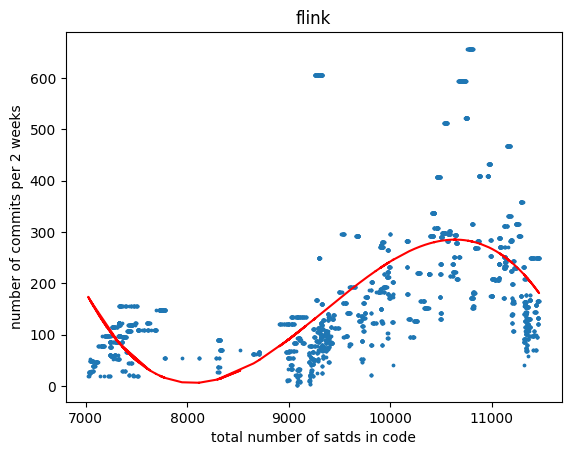

SignificanceResult(statistic=0.1338132831247832, pvalue=3.411078872060179e-61)
MSE 27856.7075942338


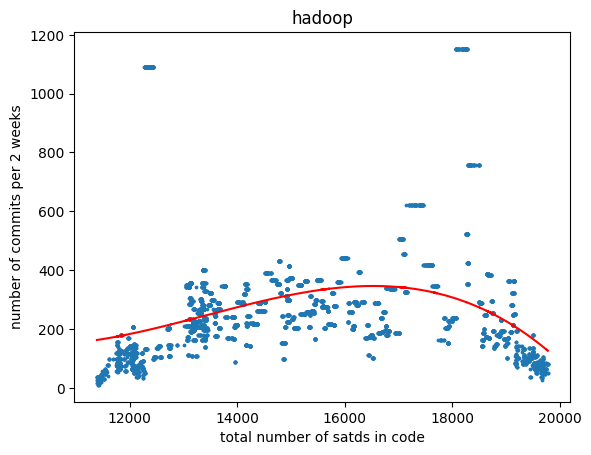

SignificanceResult(statistic=0.06384367056412442, pvalue=0.00021763348379548372)
MSE 10016.362467237344


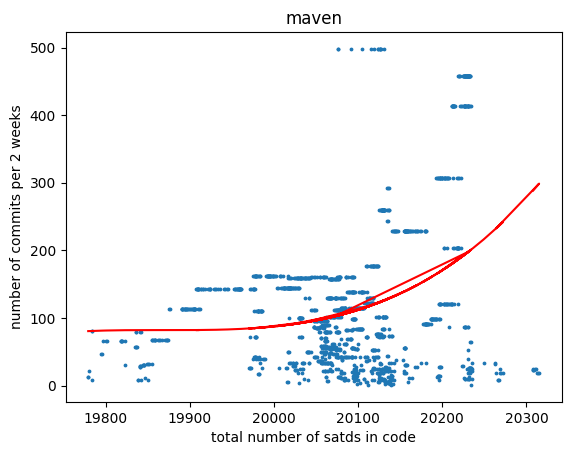

SignificanceResult(statistic=0.27445437558947156, pvalue=1.128317000641749e-22)
MSE 3992.6090041718144


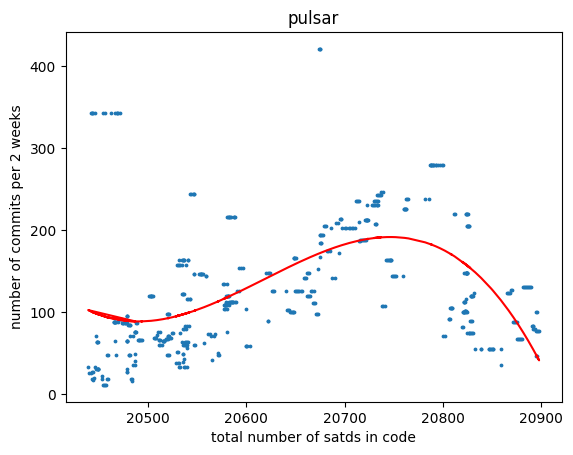

In [124]:
"""
dependence on commit speed
"""

df = pd.read_csv("data/master-dataset.csv")
df["total_cumsum"] = df["total"].cumsum()


for project in sorted(df["project"].unique()):
    
    project_df = df[df["project"] == project]
    
    print(stats.kendalltau(project_df["total_cumsum"], project_df["commits_per_14days"]))
    
    
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(project_df["total_cumsum"].to_numpy().reshape(-1, 1))
    y = project_df["commits_per_14days"].to_numpy().reshape(-1, 1)
    model = LinearRegression()
    model.fit(x_poly, y)
    predicted = model.predict(x_poly)
    print("MSE", mean_squared_error(y, predicted))

    plt.xlabel("total number of satds in code")
    plt.ylabel("number of commits per 2 weeks")
    plt.title(project)
    plt.scatter(project_df["total_cumsum"], project_df["commits_per_14days"], s=3)
    plt.plot(project_df["total_cumsum"], predicted, color="red")
    plt.savefig(f"plots/commit_frequency/{project}.png")
    plt.show()


MSE 65.1476010224695


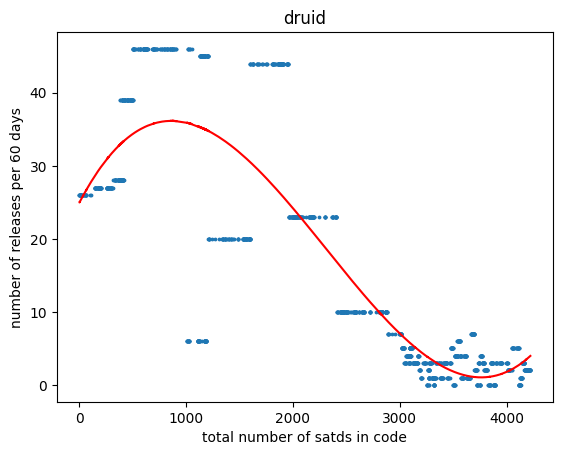

MSE 6.342779604878186


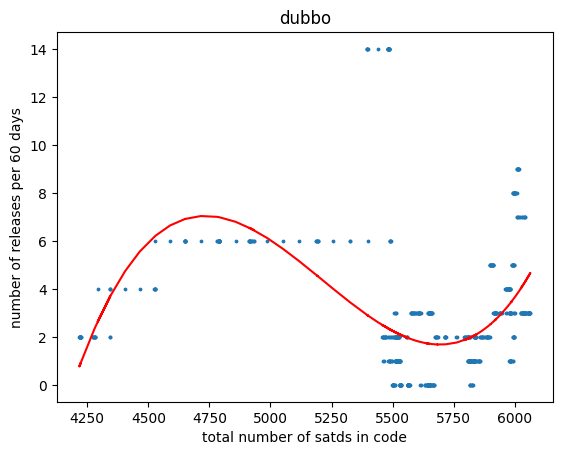

MSE 7.240718629815279


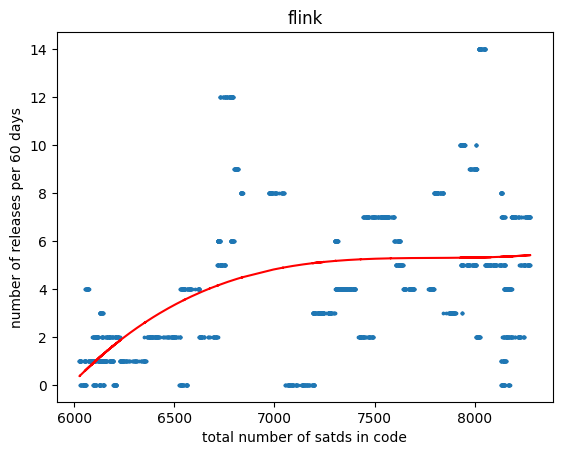

MSE 25.741112504902993


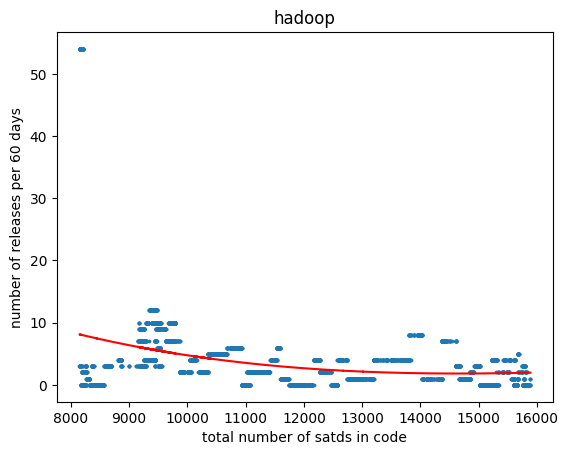

MSE 1.4516861987408143


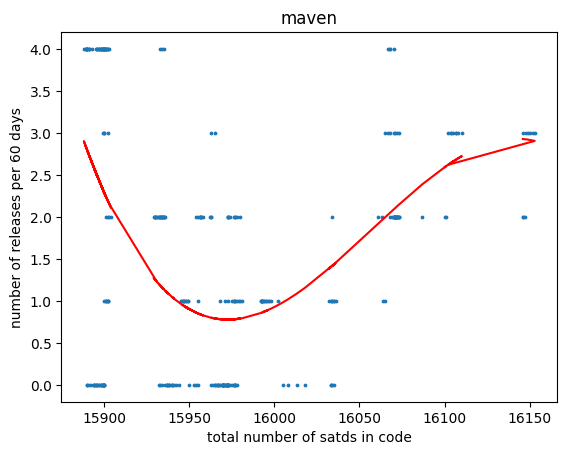

MSE 10.674902532385554


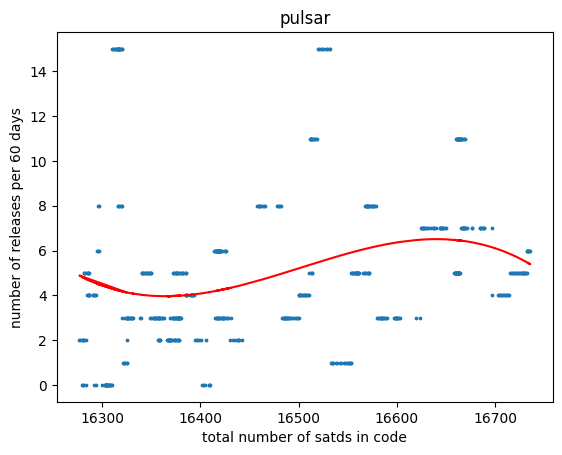

In [122]:
"""
dependence on release speed
"""

df = pd.read_csv("data/master-dataset.csv")
df.dropna(inplace=True)
df["total_cumsum"] = df["total"].cumsum()


for project in sorted(df["project"].unique()):
    
    project_df = df[df["project"] == project]
    poly = PolynomialFeatures(degree=3)
    x_poly = poly.fit_transform(project_df["total_cumsum"].to_numpy().reshape(-1, 1))
    y = project_df["releases_per_60days"].to_numpy().reshape(-1, 1)
    
    model = LinearRegression()
    model.fit(x_poly, y)
    predicted = model.predict(x_poly)
    print("MSE", mean_squared_error(y, predicted))

    plt.xlabel("total number of satds in code")
    plt.ylabel("number of releases per 60 days")
    plt.title(project)
    plt.scatter(project_df["total_cumsum"], project_df["releases_per_60days"], s=3)
    plt.plot(project_df["total_cumsum"], predicted, color="red")
    plt.savefig(f"plots/commit_frequency/{project}.png")
    plt.show()